In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
import jenkspy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pyodbc

In [9]:
cnx: pyodbc.Connection = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DWH;"
    "Database=dwOper;"
    "Trusted_Connection=yes;")

In [10]:
query = """
    SELECT p.PlayerID,
       SUM(p.OriginalAmount) Amount,
       SUM(p.PaymentCount) Counts,
       CAST(p.PaymentDate AS DATE) AS Date
    FROM [PartnersReport].[TOTOGAMINGAM].[View_FACT_Payment] p
        INNER JOIN [PartnersReport].[dbo].[DIM_PaymenSystemName] pn ON
            pn.PaymentSystemId=p.PaymentSystemId AND pn.[SourceID]=p.SourceID
    WHERE p.Paymenttype=2
      AND p.SourceID=2
      AND p.PaymentDate >='2022-12-01'
      AND p.PaymentDate < CAST(GETDATE() as date)
    GROUP BY p.PlayerID, CAST(p.PaymentDate AS DATE)
"""

In [11]:
df = pd.read_sql(query, cnx)
cnx.close()

In [12]:
df.head()

,PlayerID,Amount,Counts,Date
0,100377580,1600.0,3,2022-12-01
1,100377600,77000.0,2,2022-12-01
2,100377635,10000.0,2,2022-12-01
3,100377667,1000.0,1,2022-12-01
4,100377696,8800.0,3,2022-12-01


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
anchorDate = dt.datetime(2023,3,1)
rfm = df.groupby('PlayerID').agg({   'Date'  : lambda x: (anchorDate - x.max()).days,
                                     'Counts': lambda x: len(x),
                                     'Amount' : lambda x: x.sum()})

In [14]:
rfm.head()

,Date,Counts,Amount
PlayerID,,,
100377550,2,61,452500.0
100377551,6,17,122600.0
100377556,3,241,1081584.0
100377559,36,1,1000.0
100377560,12,17,47661.0


In [16]:
rfm.head()

,Date,Counts,Amount
PlayerID,,,
100377550,2,40,452500.0
100377551,6,14,122600.0
100377556,3,54,1081584.0
100377559,36,1,1000.0
100377560,12,3,47661.0


In [17]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [18]:
rfm.head()

,Recency,Frequency,Monetary
PlayerID,,,
100377550,2,40,452500.0
100377551,6,14,122600.0
100377556,3,54,1081584.0
100377559,36,1,1000.0
100377560,12,3,47661.0


In [19]:
rfm['r_percentile'] = rfm['Recency'].rank(pct=True,ascending=False)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 4, labels=range(4,0,-1))
rfm['f_percentile'] = rfm['Frequency'].rank(pct=True,ascending=True)
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 4, labels=range(4,0,-1))
rfm['m_percentile'] = rfm['Monetary'].rank(pct=True,ascending=True)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))

In [20]:
rfm.head()

,Recency,Frequency,Monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
PlayerID,,,,,,,,,
100377550,2,40,452500.0,0.777912,2,0.893504,1,0.902994,1
100377551,6,14,122600.0,0.616107,2,0.692043,2,0.782465,1
100377556,3,54,1081584.0,0.720772,2,0.943460,1,0.953511,1
100377559,36,1,1000.0,0.326779,3,0.098469,4,0.144839,4
100377560,12,3,47661.0,0.510986,2,0.345316,3,0.657534,2


In [21]:
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

In [22]:
rfm.head()

,Recency,Frequency,Monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score,rfm_score
PlayerID,,,,,,,,,,
100377550,2,40,452500.0,0.777912,2,0.893504,1,0.902994,1,211
100377551,6,14,122600.0,0.616107,2,0.692043,2,0.782465,1,221
100377556,3,54,1081584.0,0.720772,2,0.943460,1,0.953511,1,211
100377559,36,1,1000.0,0.326779,3,0.098469,4,0.144839,4,344
100377560,12,3,47661.0,0.510986,2,0.345316,3,0.657534,2,232


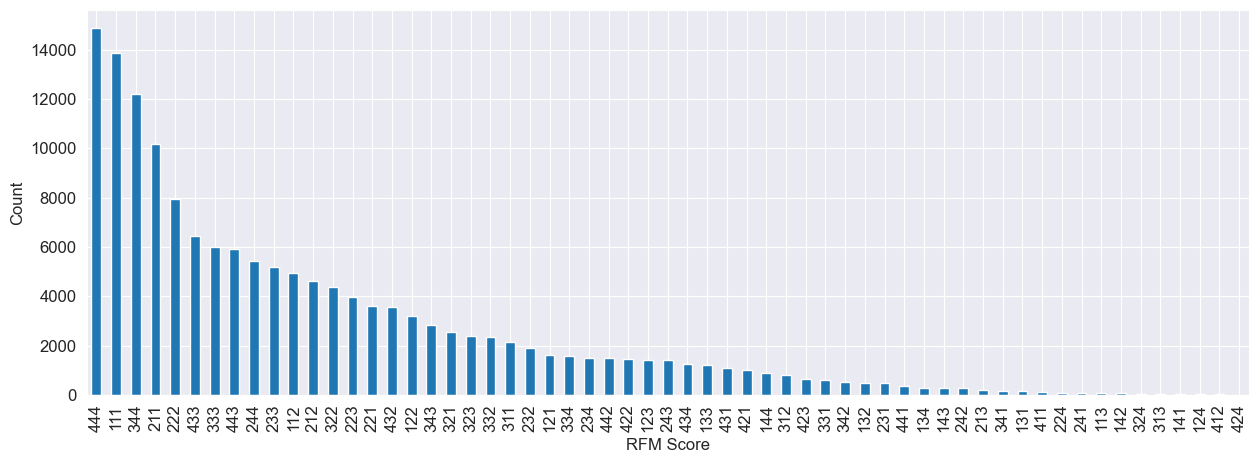

In [23]:
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [24]:
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
m_quarters = rfm['Monetary'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)),
                      columns=['Q_Recency','Q_Frequency', 'Q_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_Frequency,Q_Monetary
min,1.0,1.0,100.0
first_part,2.0,2.0,2400.0
second_part,13.0,6.0,15600.0
third_part,56.0,19.0,94052.5
max,90.0,90.0,453311455.0


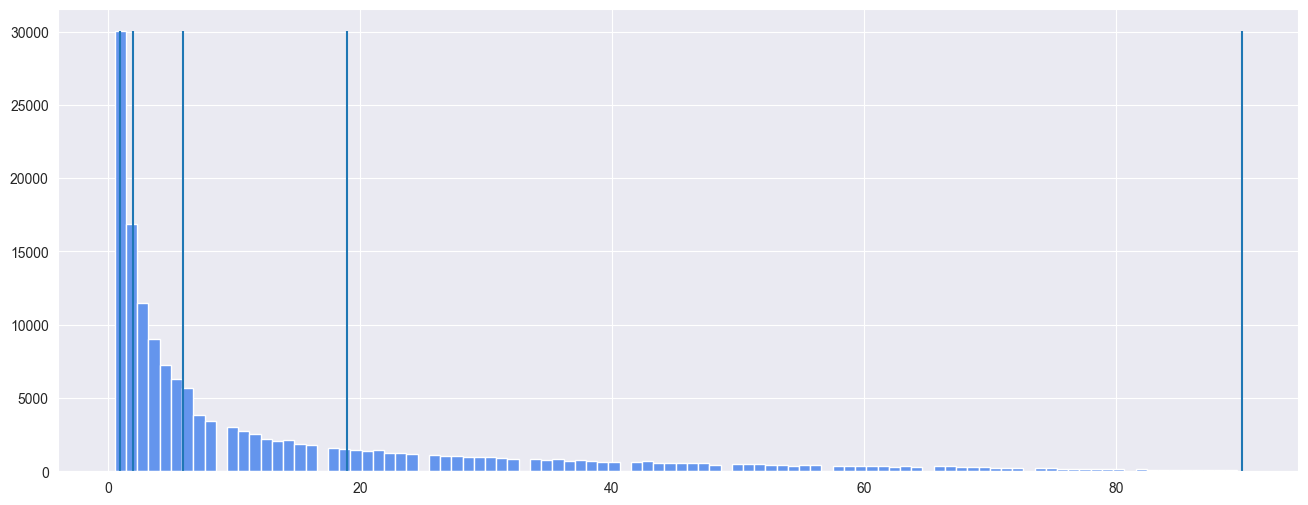

In [25]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100, align='left', color='cornflowerblue')
for q in f_quarters:
    plt.vlines(q, ymin=0, ymax = max(hist[0]))

In [28]:
r_breaks = jenkspy.jenks_breaks(rfm['Recency'], n_classes=4)
f_breaks = jenkspy.jenks_breaks(rfm['Frequency'], n_classes=4)
m_breaks = jenkspy.jenks_breaks(rfm['Monetary'], n_classes=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)),
                      columns=['J_Recency','J_Frequency', 'J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
jenks_spread

,J_Recency,J_Frequency,J_Monetary
min,1,1,100.0
first_part,13,11,9610200.0
second_part,37,29,50123324.0
third_part,67,53,178454982.0
max,90,90,453311455.0


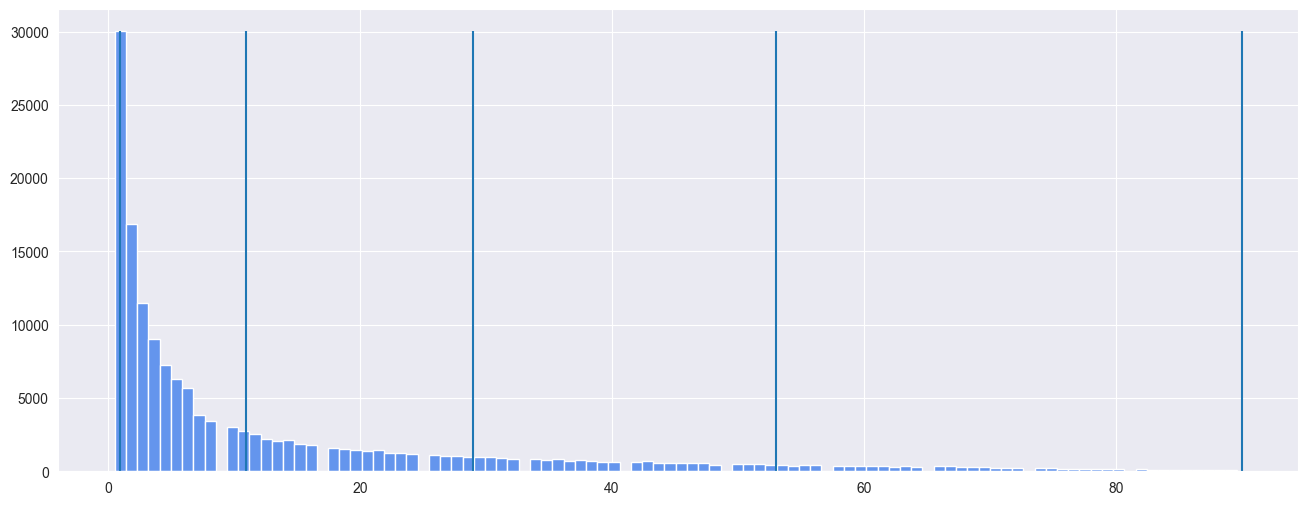

In [30]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100, align='left', color='cornflowerblue')
for b in f_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [33]:
df = pd.concat([quartile_spread, jenks_spread], axis=1)
cols = ['Q_Recency', 'J_Recency','Q_Frequency', 'J_Frequency','Q_Monetary', 'J_Monetary']
df[cols]

,Q_Recency,J_Recency,Q_Frequency,J_Frequency,Q_Monetary,J_Monetary
min,1.0,1,1.0,1,100.0,100.0
first_part,2.0,13,2.0,11,2400.0,9610200.0
second_part,13.0,37,6.0,29,15600.0,50123324.0
third_part,56.0,67,19.0,53,94052.5,178454982.0
max,90.0,90,90.0,90,453311455.0,453311455.0


In [39]:
breaks_list = [r_breaks, f_breaks, m_breaks]
rfm['r_j_score'] = pd.cut(rfm['Recency'], bins=r_breaks, labels=[1, 2, 3, 4], include_lowest=True)
rfm['f_j_score'] = pd.cut(rfm['Frequency'], bins=f_breaks, labels=[4, 3, 2, 1], include_lowest=True)
rfm['m_j_score'] = pd.cut(rfm['Monetary'], bins=m_breaks, labels=[4, 3, 2, 1], include_lowest=True)
rfm.drop(['r_percentile', 'f_percentile', 'm_percentile'], axis=1, inplace=True)
rfm['rfm_j_score'] = rfm['r_j_score'].astype(str) + rfm['f_j_score'].astype(str) + rfm['m_j_score'].astype(str)

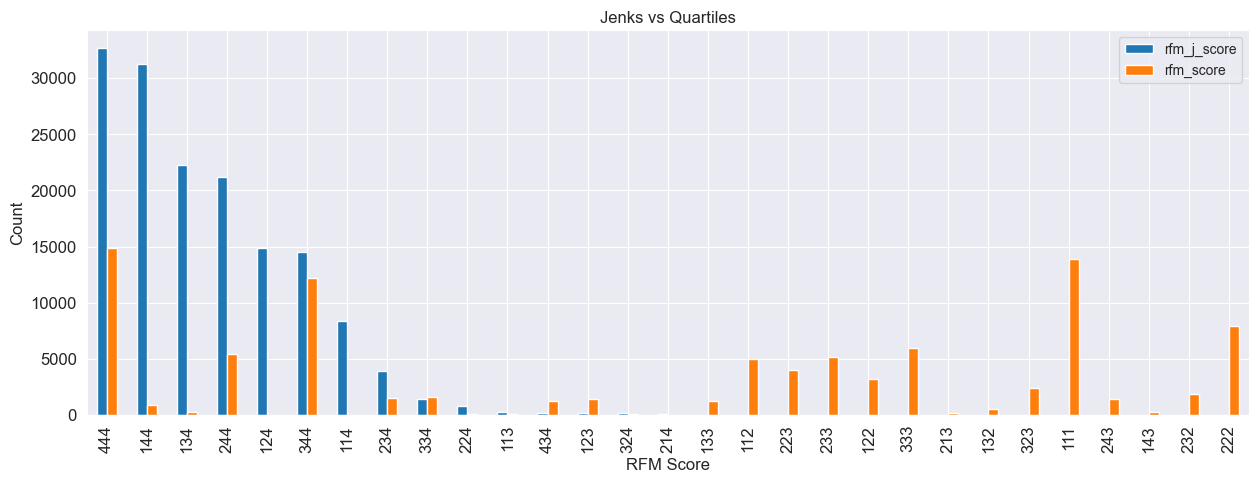

In [40]:
df = rfm['rfm_j_score'].value_counts().to_frame().join(rfm['rfm_score'].value_counts())
ax = df.plot(kind='bar', title ="Jenks vs Quartiles", figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [50]:
import hdbscan
clusterer = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=1300)
clusterer.fit(rfm[['Recency', 'Frequency', 'Monetary']])
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)
rfm.head(3)

MemoryError: 

In [ ]:
rfm['Cluster'].value_counts()

IndexError: list index out of range

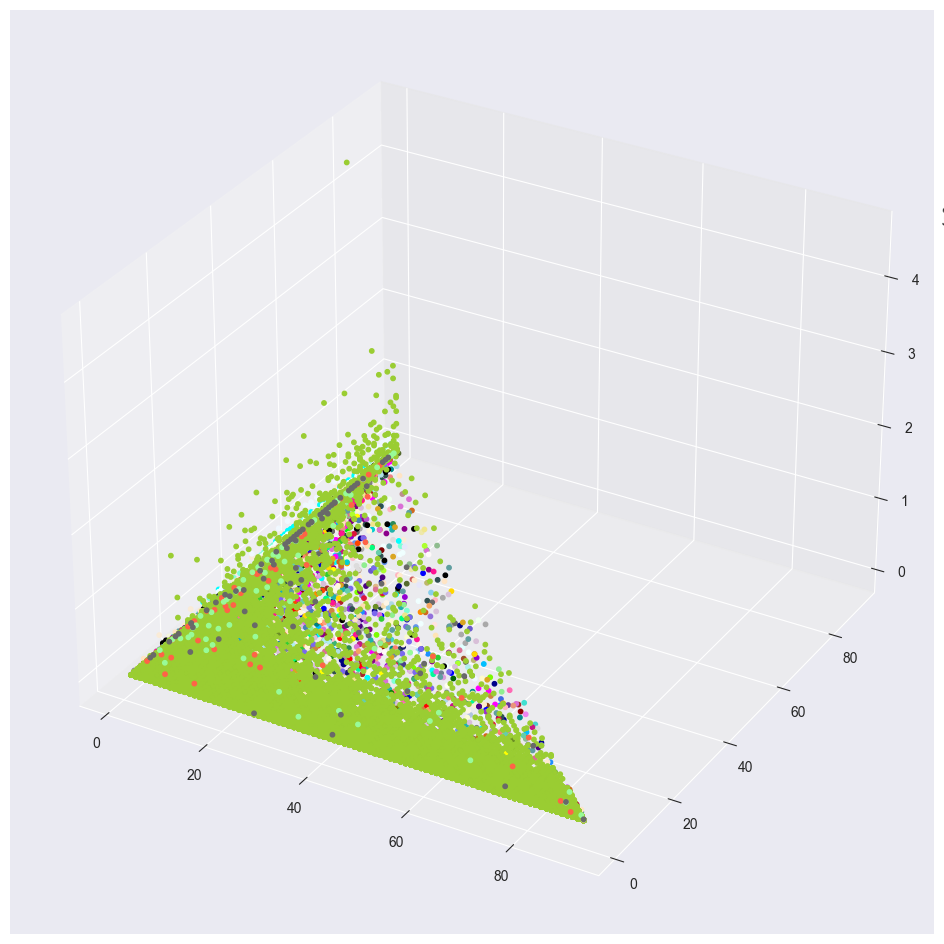

In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')
# colors = ['green', 'blue', 'red', 'yellow', 'black', 'purple', 'cyan']
colors = [ k for k in mcolors.CSS4_COLORS ]
for i in range(-1,len(rfm['Cluster'].unique())-1):
    dx.scatter(rfm[rfm.Cluster == i].Recency,
               rfm[rfm.Cluster == i].Frequency,
               rfm[rfm.Cluster == i].Monetary,
               c = colors[i],
               label = 'Cluster ' + str(i),
               s=10, alpha=1.0)
dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)